In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from collections import namedtuple
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_style("ticks")
plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})

# Set the font used for MathJax - more on this later
plt.rc('mathtext',**{'default':'regular'})

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rc('axes', titlesize=20, titleweight=3)
plt.rc('legend',fontsize='18')
plt.rcParams['legend.title_fontsize'] = '18'
colors = ['black', 'red', 'blue', 'green', 'purple', "brown", "orange", "pink"]
dashes = ['-', ':', '-.', '--', (0, (3, 5, 1, 5, 1, 5)), ":"]
mpl.rcParams['hatch.linewidth'] = 1

In [3]:
carbon_policy_labels = {
    "carbon_waiting": r"LCW",
    "carbon_oracle":  r"LCW$^*$",
    "carbon_lowest": "LCS",
    "suspend-resume_oracle": "Wait AWhile",
    "carbon_cst_oracle": r"CST$^*$",
    "carbon_cst_average": r"CST",
    "cost_oracle": "AJW-T",
    "carbon-cost_cst_average": r"RF-CST",
    "carbon-cost_waiting": r"RF-LCW",
    "carbon-spot_cst_average": r"SF-CST",
    "carbon-cost-spot_cst_average": r"SP-RES-CST"
}

carbon_start_index = 7000
task_trace = "pai_1k"
TIME_FACTOR = 5

In [4]:
def color_plot(bar, bars, points):
    hts = ['/', '//' ,'\\', '-', '.']
    hts = hts[:bars]
    cls = ['white', 'lightblue', 'lightpink', 'lightgreen', 'gainsboro']
    cls = cls[:bars]
    hatches = []
    colors = []
    for p in range(bars):
        for i in range(points):
            hatches.append(hts[p])
            colors.append(cls[p])
    # Loop over the bars
    j = 0
    for i,thisbar in enumerate(bar.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatches[i])
        thisbar.set_ec('black')
        thisbar.set_fc(colors[i])

In [5]:
def change_width(ax, new_value, move_right=0) :
    for patch, line in zip(ax.patches, ax.lines):
        current_width = patch.get_width()

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + move_right)
        
        line.set_xdata(patch.get_x() + patch.get_width() * .5)

In [6]:
def load_task_details(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str):
    if cluster_type =="slurm":
        file_name = f"../results/{cluster_type}/{task_trace}/slurm-details-{scheduling_policy}-{carbon_start_index}-{carbon_policy}-{carbon_trace}-{reserved}-{waiting_times_str}.csv"             
    else:
        file_name = f"../results/{cluster_type}/{task_trace}/details-{scheduling_policy}-{carbon_start_index}-{carbon_policy}-{carbon_trace}-{reserved}-{waiting_times_str}.csv"             
    df = pd.read_csv(file_name)
    df["carbon_policy"] = carbon_policy_labels[scheduling_policy+"_"+carbon_policy]
    df["scheduling_policy"] = scheduling_policy
    df["start_index"] = carbon_start_index
    df["task_trace"] = task_trace    
    return df

In [7]:
load_task_details("simulation", task_trace, "carbon", carbon_start_index, "oracle", "AU-SA", 0, "0x0").sum()

ID                                                              499499
arrival_time                                                  61374633
length                                                         1812837
cpus                                                              1236
length_class         0-20-20-26-120-20-20-212-2412-246-120-20-26-12...
resource_class       113-41122113-421121111111113-412111213-4111112...
carbon_cost                                                 562.171256
dollar_cost                                                  199.17586
start_time                                                    61374633
waiting_time                                                         0
exit_time                                                     63187470
reason               completedcompletedcompletedcompletedcompletedc...
carbon_policy        LCW$^*$LCW$^*$LCW$^*$LCW$^*$LCW$^*$LCW$^*$LCW$...
scheduling_policy    carboncarboncarboncarboncarboncarboncarboncarb...
start_

In [8]:
def load_task_agg(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str):
    df = load_task_details(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str)
    jobs = df.shape[0]-1
    df =  df.groupby("carbon_policy").sum().reset_index()
    df["scheduling_policy"] = scheduling_policy
    df["start_index"] = carbon_start_index
    df["task_trace"] = task_trace
    if scheduling_policy == "suspend-resume":
        df_ = load_task_details(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str)
        if cluster_type == "simulation":
            df_ = df_[df_["ID"]>=0]
        df_ = df_.groupby("ID").max().reset_index()
        #return df_
        df["waiting_time"] = df_["waiting_time"].mean()
    else:  
        df_ = load_task_details(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str)
        if cluster_type == "simulation":
            df_ = df_[df_["ID"]>=0]
        df["waiting_time"] = df_["waiting_time"].mean()
    return df

In [9]:
load_task_agg("simulation", task_trace, "carbon", carbon_start_index, "oracle", "AU-SA", 0, "6x24")

,carbon_policy,ID,arrival_time,length,cpus,carbon_cost,dollar_cost,start_time,waiting_time,exit_time,start_index,scheduling_policy,task_trace
0,LCW$^*$,499499,61374633,1812837,1236,345.384732,199.17586,66130233,4755.6,67943070,7000,carbon,pai_1k


In [10]:
def load_results_breakdown(cluster_type, task_trace, scheduling_policy, carbon_policy, carbon_trace, reserved, waiting_times_str):
    agnostic = load_task_details(cluster_type, task_trace, "carbon", carbon_start_index, "oracle", carbon_trace, 0, "0x0")
    df = load_task_details(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str)
    if cluster_type == "slurm":
        agnostic["ID"] = agnostic["ID"].apply(lambda x:x.split("-")[0])
        agnostic = agnostic[agnostic["ID"]!=""]
        agnostic["ID"] = agnostic["ID"].astype(int)
        df["ID"] = df["ID"].apply(lambda x:x.split("-")[0])
        df = df[df["ID"]!=""]
        df["ID"] = df["ID"].astype(int)
    df = df.join(agnostic,on="ID", rsuffix="_agnostic", how="inner")
    df["saved_carbon"] = df["carbon_cost_agnostic"]  - df["carbon_cost"]
    df["saved_cost"] = df["dollar_cost_agnostic"]  - df["dollar_cost"]
    df["carbon_percent"] = df["saved_carbon"]/df["carbon_cost_agnostic"] * 100
    df["cost_percent"] = df["saved_cost"]/df["dollar_cost_agnostic"] * 100 
    df = df.dropna()
    df = df[["length_class", "resource_class", "carbon_cost_agnostic","carbon_cost", "saved_carbon", "saved_cost", "carbon_percent","cost_percent"]]
    return df

In [11]:
load_results_breakdown("simulation", task_trace, "carbon", "oracle", "AU-SA", 0, "6x24")

,length_class,resource_class,carbon_cost_agnostic,carbon_cost,saved_carbon,saved_cost,carbon_percent,cost_percent
0,0-2,1,0.026706,0.026706,0.000000,0.0,0.000000,0.0
1,0-2,3-4,0.125783,0.125783,0.000000,0.0,0.000000,0.0
2,0-2,1,0.017759,0.017759,0.000000,0.0,0.000000,0.0
3,0-2,2,0.033382,0.033382,0.000000,0.0,0.000000,0.0
4,0-2,2,0.033382,0.033382,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...
995,0-2,1,0.076842,0.055123,0.021720,0.0,28.265264,0.0
996,0-2,1,0.028796,0.020665,0.008131,0.0,28.237884,0.0
997,0-2,1,0.083710,0.040736,0.042975,0.0,51.337282,0.0
998,0-2,1,0.026675,0.021790,0.004885,0.0,18.313646,0.0


In [12]:
def load_task_agg_all(cluster_type, task_trace, scheduling_policy, carbon_policy, carbon_trace, reserved, waiting_times_str):
    df = load_task_agg(cluster_type, task_trace, scheduling_policy, carbon_start_index, carbon_policy, carbon_trace, reserved, waiting_times_str)
    agnostic = load_task_agg(cluster_type, task_trace, "carbon", carbon_start_index, "oracle", carbon_trace, 0, "0x0")
    df["carbon_policy"] = carbon_policy_labels[scheduling_policy+"_"+carbon_policy]
    df["scheduling_policy"] = scheduling_policy
    if cluster_type == "simulation":
        df["saved_carbon"] = agnostic["carbon_cost"]  - df["carbon_cost"]
        df["saved_cost"] = agnostic["dollar_cost"]  - df["dollar_cost"]
        df["carbon_percent"] = df["saved_carbon"]/agnostic["carbon_cost"] * 100
        df["cost_percent"] = df["saved_cost"]/agnostic["dollar_cost"] * 100
        df["normalized_carbon"] = df["carbon_cost"]/agnostic["carbon_cost"]
        df["normalized_cost"] = df["dollar_cost"]/agnostic["dollar_cost"]
    else:
        df["saved_carbon"] = agnostic["total_carbon_cost"]  - df["total_carbon_cost"]
        df["saved_cost"] = agnostic["total_dollar_cost"]  - df["total_dollar_cost"]
        df["carbon_percent"] = df["saved_carbon"]/agnostic["total_carbon_cost"] * 100
        df["cost_percent"] = df["saved_cost"]/agnostic["total_dollar_cost"] * 100
        df["normalized_carbon"] = df["total_carbon_cost"]/agnostic["total_carbon_cost"]
        df["normalized_cost"] = df["total_dollar_cost"]/agnostic["total_dollar_cost"] 
    return df

## Plotting Figure 6.

In [13]:
def plot_policies_carbonwaiting(cluster_type, task_trace, policies, carbon_trace, reserved, waiting_times_str):
    dfs = []
    for (scheduling, policy) in policies:
        df = load_task_agg_all(cluster_type, task_trace, scheduling, policy, carbon_trace, reserved, waiting_times_str)
        dfs.append(df)
    df = pd.concat(dfs).reset_index()
    df["waiting_time"]/=720
    fig, ax = plt.subplots(ncols= 1, nrows=1, figsize=(8,3))
    bar1 = sns.barplot(x="carbon_policy", y="carbon_percent",
                         data=df, color="lightblue", ec="k", ax=ax, hatch="", label="$CO_2$", lw=1.5)
    ax.set_ylabel("Carbon Saving (%)", fontsize=15)
    ax.set_xlabel("")
    ax.set_ylim(0,45)
    ax.set_yticks(range(0,50, 15))
    
    ax2 = ax.twinx()
    
    bar1 = sns.barplot(x="carbon_policy", y="waiting_time",
                         data=df, color="lightpink", ec="k", ax=ax2, hatch="/", label="Waiting time", lw=1.5)
    ax2.set_ylabel("Waiting Time (hour)", fontsize=15)
    ax2.set_xlabel("")
    ax2.set_ylim(0,8)
    
    change_width(ax, 0.3, 0.095)
    change_width(ax2, 0.3, 0.405)
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles1+handles2, labels1+labels2, bbox_to_anchor=(0.51, 0.9), fontsize=14, columnspacing=0.5,
               loc="upper right", ncol=3, borderaxespad=0)
    
    plt.xticks(fontsize=11)
    sns.despine(fig, right=False)
    plt.tight_layout()
    fig.savefig(f'carbon_waiting_{cluster_type}_{carbon_trace}.png',  bbox_inches = 'tight', transparent=True)
    return df[["carbon_policy", "carbon_percent", "waiting_time"]]

,carbon_policy,carbon_percent,waiting_time
0,LCS,21.996273,5.637933
1,LCW,31.629598,6.645000
2,CST,27.511177,4.729000
3,LCW$^*$,38.562364,6.605000
4,CST$^*$,34.210783,4.607000
5,Wait AWhile,39.249131,6.726990


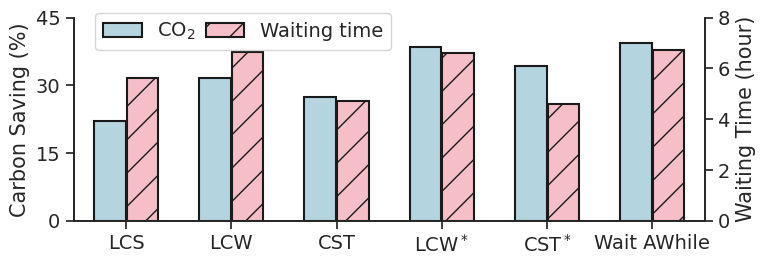

In [14]:
cluster_type = "simulation"
carbon_trace = "AU-SA"
policies = [ 
    ("carbon", "lowest"),
    ("carbon", "waiting"),
    ("carbon", "cst_average"),
    ("carbon", "oracle"),
    ("carbon", "cst_oracle"),
    ("suspend-resume", "oracle"),
]

plot_policies_carbonwaiting(cluster_type, task_trace, policies, carbon_trace, 0, "6x24")

## Plot Figure 7.

In [15]:
def plot_carbon_percent_length(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, reserved, waiting_times_str):
    df = load_results_breakdown(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, reserved, waiting_times_str)
    df = df.groupby("length_class").mean().reset_index()
    df["carbon_percent"] = df["saved_carbon"]/df["carbon_cost_agnostic"] * 100
    df["length_class"] = pd.Categorical(df["length_class"], categories = ["0-2", "2-6", "6-12", "12-24", "24-48", "48+"])
    
    df = df.sort_values(by = "length_class").reset_index()
    #return df
    #return df
    fig, ax = plt.subplots(ncols= 1, nrows=1, figsize=(8,3))
    sns.barplot(x="length_class", y="carbon_percent", data=df, 
                color="lightblue", ec="k", hatch="", lw=1.5, ax=ax,
                label="Carbon Saving (%)"
               )    
        
    ax.set_xlabel("Task Length")
    df = load_results_breakdown(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, reserved, waiting_times_str)
    df = df.groupby("length_class").sum().reset_index()    
    df["saved_carbon"]/= df["saved_carbon"].sum()
    df["saved_carbon"]*=100
    
    df["carbon_percent"] = df["saved_carbon"]/df["carbon_cost_agnostic"] * 100
    df["length_class"] = pd.Categorical(df["length_class"], categories = ["0-2", "2-6", "6-12", "12-24", "24-48", "48+"])
    
    ax2 = ax.twinx()
    sns.barplot(
        x="length_class", y="saved_carbon", data=df,
        color="lightpink", ec="k", hatch="/", lw=1.5,
        ax = ax2,   label=r"Total Contribution (%)"        
    )
    
    change_width(ax, 0.3, 0.095)
    change_width(ax2, 0.3, 0.405)
    
    ax.set_ylim([0, 50])
    ax.set_yticks(range(0, 60, 10))
    
    ax.tick_params(axis='y', colors="black")
    ax.set_ylabel("Carbon Saving (%)", fontsize=15)
    

    #ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
    
    #ax2.grid(None)
    ax2.set_ylim([0, 40])
    ax2.tick_params(axis='y')
    ax2.set_ylabel("Carbon Savings \n Contribution (%)", fontsize=15)

    
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles1+handles2, labels1+labels2, fontsize=14, 
               bbox_to_anchor=(0.84, 0.85), 
               loc="upper right", ncol=1, borderaxespad=0)
    sns.despine(fig, right=False)

    plt.tight_layout()
    fig.savefig(f'carbon_breakdown_{cluster_type}_{carbon_trace}_length.png',  bbox_inches = 'tight', transparent=True)
    return df

,length_class,carbon_cost_agnostic,carbon_cost,saved_carbon,saved_cost,carbon_percent,cost_percent
0,0-2,99.248919,75.182839,15.560644,0.105560,15.678401,-49.482183
1,12-24,129.848633,101.822539,18.121109,-0.508647,13.955564,-435.385757
2,2-6,78.712998,46.030030,21.132149,0.571740,26.847090,97.047840
3,24-48,105.877030,90.264599,10.094684,0.000000,9.534347,-0.004690
4,48+,32.747283,29.511520,2.092179,0.000000,6.388864,0.000000
5,6-12,115.736393,64.699798,32.999235,-0.168653,28.512410,-97.543860


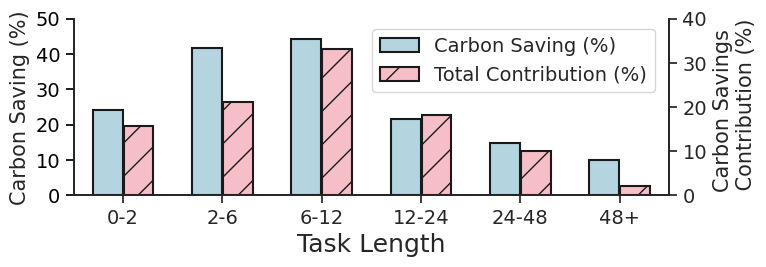

In [16]:
cluster_type = "simulation"
carbon_trace = "AU-SA"
policy = "cst_average"
plot_carbon_percent_length(cluster_type, task_trace, "carbon", policy, carbon_trace, 0, "6x24")

## Plot Figure 8

In [17]:
def plot_cost_percent_clustertraces(cluster_type, policies, carbon_trace, waiting_times, reserved):
    dfs = []
    
    try:
        df = load_task_agg_all(cluster_type, task_trace, "carbon", "oracle", carbon_trace, reserved, "0x0")
        df["carbon_policy"] = "NJW"
        dfs.append(df)
    except:
        pass
    
    for (scheduling_policy, policy) in policies:
        df = load_task_agg_all(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, reserved, waiting_times)
        dfs.append(df)
        #if scheduling_policy =="suspend-resume":
            #df["normalized_cost"] = 0.92
            #print(df)
    
    try:
        df = load_task_agg_all(cluster_type, task_trace, "cost", "oracle", carbon_trace, reserved, "1000x1000")
        df["carbon_policy"] = "AJW"
        #dfs.append(df)
    except:
        pass
    
    
    
    
    df = pd.concat(dfs).reset_index()
    #df.loc[df["scheduling_policy"] == "Carbon", "scheduling_policy"] = "On-Demand"
    #df.loc[df["scheduling_policy"] == "Reserved", "scheduling_policy"] = "Res. First (RF)"
    df["normalized_waiting"]= df["waiting_time"]/df["waiting_time"].max()
    df["normalized_carbon"]= df["normalized_carbon"]/df["normalized_carbon"].max()
    df["normalized_cost"]= df["normalized_cost"]/df["normalized_cost"].max()
    
    df = df[["carbon_policy", "normalized_carbon", "normalized_cost", "normalized_waiting"]]    
    df = df.rename(columns={"normalized_carbon": "Carbon", "normalized_cost": "Cost", "normalized_waiting": "Waiting Time"})
    tidy = df.melt(id_vars='carbon_policy').rename(columns=str.title)
    fig, ax = plt.subplots(ncols= 1, nrows=1, figsize=(8,2.5))
    
    bar = sns.barplot(x='Carbon_Policy', y='Value', hue='Variable', data=tidy, ax=ax, ec="black", lw=2)
    color_plot(bar, 3,len(dfs))
    ax.set_ylim(0,1)
    ax.set_ylabel("Metric")
    ax.set_xlabel("")
    sns.despine(fig)
    plt.tight_layout()
    ax.legend(title=None, loc="upper center", fontsize=15, ncol=3, bbox_to_anchor=(0.5, 1.35))
    fig.savefig(f'{cluster_type}_carbon_cost_{carbon_trace}.png',  bbox_inches = 'tight', transparent=True)
    return tidy
    #return df.groupby(["cluster_trace", "scheduling_policy"]).mean()

,Carbon_Policy,Variable,Value
0,NJW,Carbon,1.000000
1,AJW-T,Carbon,0.921652
2,Wait AWhile,Carbon,0.607509
3,LCW,Carbon,0.683704
4,CST,Carbon,0.724888
5,RF-LCW,Carbon,0.822492
6,RF-CST,Carbon,0.854406
7,NJW,Cost,0.840458
8,AJW-T,Cost,0.706711
9,Wait AWhile,Cost,0.971643


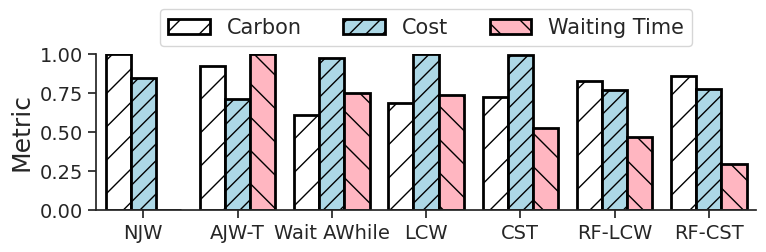

In [18]:
cluster_type="simulation"
carbon_trace = "AU-SA"
reserved = 9
policies = [ 
    ("cost", "oracle"),#ok
    ("suspend-resume", "oracle"),#no
    ("carbon", "waiting"), #ok
    ("carbon", "cst_average"), #ok
    ("carbon-cost", "waiting"),#ok
    ("carbon-cost", "cst_average"),#ok
]
waiting_times="6x24"
plot_cost_percent_clustertraces(cluster_type=cluster_type,policies=policies, carbon_trace=carbon_trace, waiting_times=waiting_times, reserved=reserved)

## Plot Figure 9

In [19]:
def plot_carbon_cost(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, waiting_times_str):
    dfs = []
    for reserved in [0, 3, 6, 9, 12, 15, 18, 21, 24]:
        try:
            if reserved == 0:
                df = load_task_agg_all(cluster_type, task_trace, "carbon", policy, carbon_trace, reserved, waiting_times_str)
                #df["waiting_time"] = load_task_details(cluster_type, task_trace, "carbon", carbon_start_index, policy, carbon_trace, reserved, waiting_times_str)["waiting_time"].mean()/(3600 / TIME_FACTOR)
            else:
                df = load_task_agg_all(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, reserved, waiting_times_str)
                #df["waiting_time"] = load_task_details(cluster_type, task_trace, scheduling_policy, carbon_start_index, policy, carbon_trace, reserved, waiting_times_str)["waiting_time"].mean()/(3600 / TIME_FACTOR)
            df["reserved"] = reserved
            dfs.append(df)
        except:
            pass
    df = pd.concat(dfs).reset_index()
    df["waiting_time"] /= 720
    fig, ax = plt.subplots(ncols= 1, nrows=1, figsize=(8,3))
    sns.lineplot(x="reserved", y="normalized_cost", data=df, color="black", ax=ax, lw=2, ms=10,ls="--",
                label="Cost"
               )    
        
    ax.set_xlabel("Reserved Instances")
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 3))

    sns.lineplot(
        x="reserved", y="normalized_carbon", data=df, color="brown", lw=2, ms=6,ls="-",
        ax = ax,
                label=r"Carbon"
        
    )
    ax.legend(loc="center right", 
              fontsize=18,ncol=1)
    
    ax.set_ylim([0.5, 1])
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.tick_params(axis='y', colors="black")
    ax.set_ylabel("Normalized Metric",  fontsize=15)
    ax2 = ax.twinx()
    
    sns.lineplot(
        x="reserved", y="waiting_time", data=df, color="red", ls=":", lw=2, ms=6,
        ax = ax2,
                label=r"Waiting Time"
        
    )
    ax2.set_ylim(0, 5)
    ax2.set_yticks(range(0, 6, 1))
    
    ax2.tick_params(axis='y', colors="black")
    ax2.set_ylabel("Waiting Time (hour)", fontsize=15)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=16)
    
    sns.despine(fig, right=False)
    plt.tight_layout()
    
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1+handles2, labels1+labels2, #bbox_to_anchor=(0.5, 0.2), 
              loc="center right", 
              fontsize=14,ncol=1, borderaxespad=0)
    #ax.legend().remove()
    
    ax2.legend().remove()
    fig.savefig(f'{cluster_type}_carbon_cost_tradeoff_{carbon_trace}.png',  bbox_inches = 'tight', transparent=True)
    return df
    
    #plt.tight_layout()
    #return df

,index,carbon_policy,ID,arrival_time,length,cpus,carbon_cost,dollar_cost,start_time,waiting_time,...,start_index,scheduling_policy,task_trace,saved_carbon,saved_cost,carbon_percent,cost_percent,normalized_carbon,normalized_cost,reserved
0,0,CST,499499,61374633,1812837,1236,407.511325,199.175860,64779513,4.729000,...,7000,carbon,pai_1k,154.659931,0.000000,27.511177,0.000000,0.724888,1.000000,0
1,0,RF-CST,499499,61374633,1812837,1236,436.434616,178.261269,64332273,4.107833,...,7000,carbon-cost,pai_1k,125.736640,20.914591,22.366252,10.500565,0.776337,0.894994,3
2,0,RF-CST,499499,61374633,1812837,1236,458.996838,159.717792,63738153,3.282667,...,7000,carbon-cost,pai_1k,103.174418,39.458068,18.352845,19.810668,0.816472,0.801893,6
3,0,RF-CST,499499,61374633,1812837,1236,480.322255,142.148535,63278080,2.643676,...,7000,carbon-cost,pai_1k,81.849001,57.027325,14.559443,28.631645,0.854406,0.713684,9
4,0,RF-CST,499499,61374633,1812837,1236,499.898230,124.225123,62864286,2.068963,...,7000,carbon-cost,pai_1k,62.273026,74.950737,11.077234,37.630432,0.889228,0.623696,12
5,0,RF-CST,499499,61374633,1812837,1236,521.492397,108.940347,62411578,1.440201,...,7000,carbon-cost,pai_1k,40.678859,90.235513,7.236026,45.304443,0.927640,0.546956,15
6,0,RF-CST,499499,61374633,1812837,1236,540.444626,106.546111,62082424,0.983043,...,7000,carbon-cost,pai_1k,21.726630,92.629749,3.864771,46.506514,0.961352,0.534935,18
7,0,RF-CST,499499,61374633,1812837,1236,550.879753,109.023581,61833768,0.637687,...,7000,carbon-cost,pai_1k,11.291503,90.152279,2.008552,45.262653,0.979914,0.547373,21
8,0,RF-CST,499499,61374633,1812837,1236,556.380473,110.262065,61724487,0.485908,...,7000,carbon-cost,pai_1k,5.790783,88.913795,1.030075,44.640849,0.989699,0.553592,24


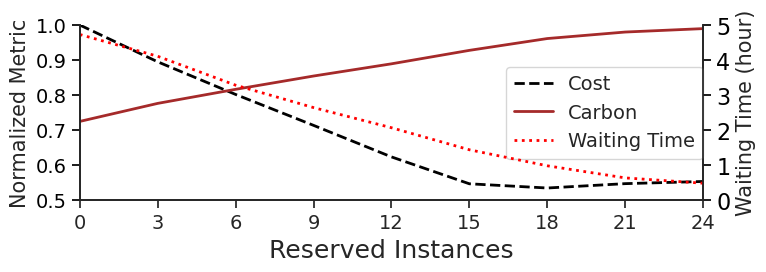

In [20]:
cluster_type = "simulation"
carbon_trace = "AU-SA"
plot_carbon_cost(cluster_type, task_trace, "carbon-cost", "cst_average", carbon_trace, "6x24")

# Figure 10

In [21]:
def plot_spot(cluster_type, policies, carbon_trace, waiting_times_str):
    dfs = []
    
    df = load_task_agg_all(cluster_type, task_trace, "carbon", "oracle", carbon_trace, 0, "0x0")        
    df["carbon_policy"] = f"NJW\n({0})"#carbon_policy_labels[scheduling_policy+"_"+policy] +f"\n{reserved}"
    dfs.append(df)
    
    for (scheduling_policy, policy, reserved) in policies:
        try:
            df = load_task_agg_all(cluster_type, task_trace, scheduling_policy, policy, carbon_trace, reserved, waiting_times_str)        
            df["carbon_policy"] = carbon_policy_labels[scheduling_policy+"_"+policy] +f"\n({reserved})"
            dfs.append(df)
        except:
            pass
    
   
    
    df = pd.concat(dfs).reset_index()
    
    df = df[["carbon_policy", "normalized_carbon", "normalized_cost"]]   
    
    df = df.rename(columns={"normalized_carbon": "Carbon", "normalized_cost": "Cost"})
    tidy = df.melt(id_vars='carbon_policy').rename(columns=str.title)
    fig, ax = plt.subplots(ncols= 1, nrows=1, figsize=(8,2.5))
    
    bar = sns.barplot(x='Carbon_Policy', y='Value', hue='Variable', data=tidy, ax=ax, ec="black", lw=2)
    color_plot(bar, 3,len(dfs))
    ax.set_ylim(0.4,1)
    ax.set_ylabel("Metric")
    ax.set_xlabel("")
    sns.despine(fig)
    plt.tight_layout()
    ax.legend(title=None, loc="upper center", fontsize=15, ncol=3, bbox_to_anchor=(0.75, 1.15))
    fig.savefig(f'{cluster_type}_spot_{carbon_trace}.png',  bbox_inches = 'tight', transparent=True)
    return tidy

,Carbon_Policy,Variable,Value
0,NJW\n(0),Carbon,1.000000
1,CST\n(9),Carbon,0.724888
2,SF-CST\n(0),Carbon,0.724888
3,SP-RES-CST\n(9),Carbon,0.861709
4,SP-RES-CST\n(6),Carbon,0.812169
5,NJW\n(0),Cost,1.000000
6,CST\n(9),Cost,0.910656
7,SF-CST\n(0),Cost,0.858983
8,SP-RES-CST\n(9),Cost,0.589779
9,SP-RES-CST\n(6),Cost,0.666424


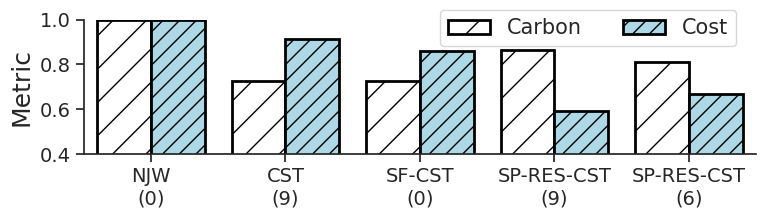

In [22]:
cluster_type="simulation"
carbon_trace = "AU-SA"
reserved = 9
policies = [ 
    
    ("carbon", "cst_average", reserved),
    ("carbon-spot", "cst_average", 0),    
    ("carbon-cost-spot", "cst_average", 9),
    ("carbon-cost-spot", "cst_average", 6),
    
]
waiting_times_str="6x24"
plot_spot(cluster_type="simulation",policies=policies, carbon_trace=carbon_trace, waiting_times_str=waiting_times_str)